# Lista de exercísios #4

**Dataset:** `/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv` 

**Context:** Usando NN nos dados reais do LHCb o decaimento $ B \to K^{*}\mu^+\mu^- $  

In [34]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [18]:
# ====== caminho do seu CSV ======
CSV_PATH = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
assert os.path.exists(CSV_PATH), f"CSV não encontrado em {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
assert 'label' in df.columns, "CSV precisa conter a coluna 'label' (0=fundo, 1=sinal)."

print(df.shape, "linhas x colunas")
df.head()

(20001, 18) linhas x colunas


,B0_M,B0_P,B0_PT,B0_DIRA_OWNPV,B0_ENDVERTEX_CHI2,B0_TAU,K_PIDK,Pi_PIDK,mu_plus_PIDmu,mu_minus_PIDmu,B0_FDCHI2_OWNPV,B0_IPCHI2_OWNPV,K_IPCHI2_OWNPV,Pi_IPCHI2_OWNPV,mu_plus_IPCHI2_OWNPV,mu_minus_IPCHI2_OWNPV,q2,label
0,5293.991001,75896.203841,8909.803377,0.999999,4.905650,0.001284,90.508797,-46.337502,12.187781,7.432416,3081.747660,0.371431,59.050087,83.338387,1780.312976,28.701731,9.663302,1
1,5288.832014,126115.585086,10691.039729,1.000000,2.004244,0.001243,24.425800,-30.905701,2.919568,6.710679,2156.295071,0.518954,117.929828,16.125493,148.942208,193.719177,9.641775,1
2,5295.424405,114864.557485,2406.324645,0.999998,12.073755,0.002071,28.216801,-18.581900,6.832418,9.504477,2660.020136,2.568881,27.325995,15.858291,1612.783038,468.393934,9.759748,1
3,5269.043465,54960.554640,2282.680501,0.999985,1.617552,0.001040,27.841700,-56.836899,4.109861,8.587584,607.622240,1.330499,80.198100,98.543575,290.049372,65.434165,9.535254,1
4,5283.438848,152677.844241,7923.259410,1.000000,4.073691,0.004821,6.273400,-31.115299,6.782620,10.778706,30945.021839,5.415031,641.926005,318.035248,1603.637163,10081.557016,9.629298,1


n_features: 15
features usadas: ['B0_P', 'B0_PT', 'B0_DIRA_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_TAU', 'K_PIDK', 'Pi_PIDK', 'mu_plus_PIDmu', 'mu_minus_PIDmu', 'B0_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'K_IPCHI2_OWNPV', 'Pi_IPCHI2_OWNPV', 'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV']


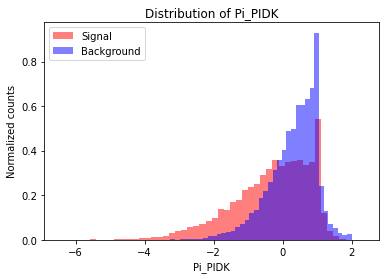

Tamanho do treino: (15000, 15), teste: (5001, 15)


In [42]:
# usamos todas as colunas exceto 'label', 'B0_M' e 'q2'
num_cols = [c for c in df.columns if c not in ['label', 'B0_M','q2']]
X_raw = df[num_cols].values
y = df['label'].astype(int).values

# informações básicas do dataset
print("n_features:", X.shape[1])
print("features usadas:", num_cols)

# Normalizar 
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

var_index = 6
var_name = num_cols[var_index]

# separa sinal e background
X_sig = X[y == 1, var_index]
X_bkg = X[y == 0, var_index]

# plota histogramas normalizados
plt.hist(X_sig, bins=50, density=True, alpha=0.5, color='red', label='Signal')
plt.hist(X_bkg, bins=50, density=True, alpha=0.5, color='blue', label='Background')

plt.xlabel(var_name)
plt.ylabel('Normalized counts')
plt.legend()
plt.title(f'Distribution of {var_name}')
plt.show()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tamanho do treino: {X_train.shape}, teste: {X_test.shape}")


# Criando modelo de DNN basico!

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Vamos compilar e rodar

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7980 - auc_1: 0.9096 - loss: 0.4555 - val_accuracy: 0.8930 - val_auc_1: 0.9568 - val_loss: 0.2764
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8992 - auc_1: 0.9634 - loss: 0.2503 - val_accuracy: 0.9033 - val_auc_1: 0.9633 - val_loss: 0.2476
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8980 - auc_1: 0.9635 - loss: 0.2460 - val_accuracy: 0.9063 - val_auc_1: 0.9655 - val_loss: 0.2378
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9067 - auc_1: 0.9697 - loss: 0.2238 - val_accuracy: 0.9090 - val_auc_1: 0.9680 - val_loss: 0.2287
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9129 - auc_1: 0.9717 - loss: 0.2162 - val_accuracy: 0.9103 - val_auc_1: 0.9695 - val_loss: 0.2245
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9160 - auc_1: 0.9741 - loss: 0.2074 - val_accuracy: 0.9123 - val_auc_1: 0.9713 - val_loss: 0.2180
Epoch 7/10
188/1

# Avaliar o desempenho do treino

In [23]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test accuracy: {results[1]:.3f}, Test AUC: {results[2]:.3f}")


 Test accuracy: 0.924, Test AUC: 0.977


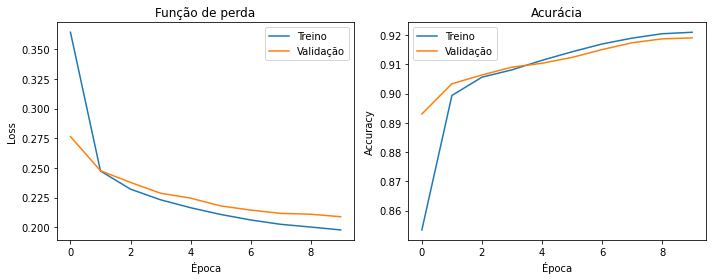

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Função de perda')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


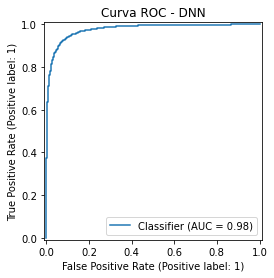

In [25]:
# ROC
from sklearn.metrics import RocCurveDisplay

y_score = model.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_score)
plt.title("Curva ROC - DNN")
plt.show()

# Testes basicos

In [43]:
model_revised = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),   # nova camada escondida
    Dense(1, activation='sigmoid')
])

model_revised.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

history_revised = model_revised.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
results_revised = model_revised.evaluate(X_test, y_test, verbose=0)
print(f"\n Test accuracy: {results_revised[1]:.3f}, Test AUC: {results_revised[2]:.3f}")

Epoch 1/10


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8455 - auc_2: 0.9159 - loss: 0.3924 - val_accuracy: 0.9023 - val_auc_2: 0.9646 - val_loss: 0.2404
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9060 - auc_2: 0.9684 - loss: 0.2285 - val_accuracy: 0.9107 - val_auc_2: 0.9696 - val_loss: 0.2267
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9102 - auc_2: 0.9729 - loss: 0.2113 - val_accuracy: 0.9200 - val_auc_2: 0.9727 - val_loss: 0.2120
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9196 - auc_2: 0.9759 - loss: 0.1994 - val_accuracy: 0.9170 - val_auc_2: 0.9739 - val_loss: 0.2074
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9209 - auc_2: 0.9756 - loss: 0.2001 - val_accuracy: 0.9233 - val_auc_2: 0.9748 - val_loss: 0.2048
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9269 - auc_2: 0.9773 - loss: 0.1919 - val_accuracy: 0.9207 - val_auc_2: 0.9750 - val_loss: 0.2038
Epoch 7/10
188/188 ━━━━━━━━

# Vamos fazer o mesmo exemplo agora em Pytorch

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [27]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

In [29]:
# Criando os loaders
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

# Modelo

In [31]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = SimpleNN(X_train.shape[1])

In [32]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Finalmente o treino

In [35]:
epochs = 20
train_loss = []
val_auc = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    # Avaliação a cada época
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t).numpy()
        auc = roc_auc_score(y_test, y_pred)
    train_loss.append(epoch_loss / len(train_loader.dataset))
    val_auc.append(auc)

    print(f"Epoch {epoch+1:02d} | Loss={train_loss[-1]:.4f} | Val AUC={auc:.3f}")


Epoch 01 | Loss=0.2391 | Val AUC=0.971
Epoch 02 | Loss=0.2268 | Val AUC=0.974
Epoch 03 | Loss=0.2191 | Val AUC=0.976
Epoch 04 | Loss=0.2171 | Val AUC=0.976
Epoch 05 | Loss=0.2114 | Val AUC=0.977
Epoch 06 | Loss=0.2081 | Val AUC=0.978
Epoch 07 | Loss=0.2083 | Val AUC=0.978
Epoch 08 | Loss=0.2056 | Val AUC=0.978
Epoch 09 | Loss=0.2033 | Val AUC=0.979
Epoch 10 | Loss=0.2016 | Val AUC=0.979
Epoch 11 | Loss=0.1993 | Val AUC=0.979
Epoch 12 | Loss=0.1984 | Val AUC=0.979
Epoch 13 | Loss=0.1975 | Val AUC=0.979
Epoch 14 | Loss=0.1970 | Val AUC=0.979
Epoch 15 | Loss=0.1967 | Val AUC=0.980
Epoch 16 | Loss=0.1924 | Val AUC=0.980
Epoch 17 | Loss=0.1936 | Val AUC=0.980
Epoch 18 | Loss=0.1893 | Val AUC=0.980
Epoch 19 | Loss=0.1907 | Val AUC=0.980
Epoch 20 | Loss=0.1891 | Val AUC=0.980


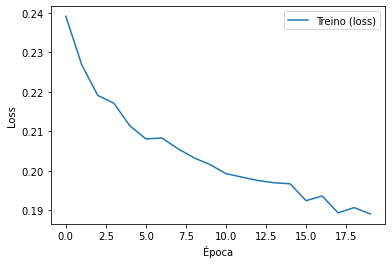

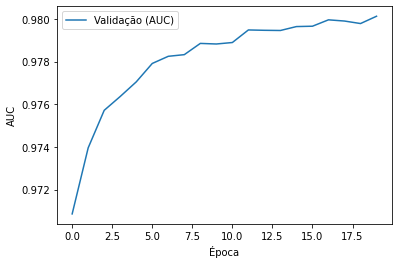

AUC final no teste: 0.980


In [36]:
plt.figure(figsize=(6,4))
plt.plot(train_loss, label="Treino (loss)")
plt.xlabel("Época"); plt.ylabel("Loss")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_auc, label="Validação (AUC)")
plt.xlabel("Época"); plt.ylabel("AUC")
plt.legend(); plt.show()

with torch.no_grad():
    y_pred = model(X_test_t).numpy()
print(f"AUC final no teste: {roc_auc_score(y_test, y_pred):.3f}")